<a href="https://colab.research.google.com/github/frznmn/RCJ_239_OnStage_Smile/blob/main/rirmware/Camera/Neural_Networks/Oleg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import skimage
import time
import os
import PIL
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from imageio.v2 import imsave,imread
from keras import optimizers
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D
from keras.models import Sequential,load_model
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from PIL import Image, ImageDraw
from scipy.ndimage import binary_fill_holes
from tqdm import trange

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
dim=64

In [4]:
try:
  X_all=np.load('./drive/MyDrive/Colab Notebooks/X.npy')
  Y_all=np.load('./drive/MyDrive/Colab Notebooks/Y.npy')
  bg=np.load('./drive/MyDrive/Colab Notebooks/bg.npy')
  tbg=np.load('./drive/MyDrive/Colab Notebooks/tbg.npy')
  rooms=np.load('./drive/MyDrive/Colab Notebooks/rooms.npy')
except Exception:
  X_all=np.load('./drive/MyDrive/X.npy')
  Y_all=np.load('./drive/MyDrive/Y.npy')
  bg=np.load('./drive/MyDrive/bg.npy')
  tbg=np.load('./drive/MyDrive/tbg.npy')
  rooms=np.load('./drive/MyDrive/rooms.npy')

In [5]:
def binarize(img):
  v=[[],[],[],[]]
  prew_img=skimage.filters.prewitt(img)
  threshold=skimage.filters.threshold_otsu(prew_img)
  for x in range(64):
    for y in range(64):
      if prew_img[x,y]<=threshold: 
        prew_img[x,y]=0
      else: 
        prew_img[x,y]=1
  img=prew_img.copy()
  l=list(img[0])
  if 1 in l:
    v[0].append(l.index(1))
    l.reverse()
    v[0].append(62-l.index(1))
  l=list(img[:,0])
  if 1 in l:
    v[1].append(l.index(1))
    l.reverse()
    v[1].append(62-l.index(1))
  l=list(img[63])
  if 1 in l:
    v[2].append(l.index(1))
    l.reverse()
    v[2].append(62-l.index(1))
  l=list(img[:,63])
  if 1 in l:
    v[3].append(l.index(1))
    l.reverse()
    v[3].append(62-l.index(1))
  for i in range(4):
    if len(v[i])!=0:
      if abs(v[i][0]-v[i][1])<=1:
        v[i][v[i].index(max(v[i]))]=63
        v[i].sort()
  for x in range(64):
    for y in range(64):
      if prew_img[x,y]==1 or (len(v[1])!=0 and (x in range(min(v[1]),max(v[1])+1))):
        img[x,y:]=1
        break
  for x in range(64):
    for y in range(63,-1,-1):
      if prew_img[x,y]==1 and not (len(v[3])!=0 and (x in range(min(v[3]),max(v[3])+1))):
        img[x,y:]=0
        break
  for y in range(64):
    for x in range(64):
      if prew_img[x,y]==1 and not (len(v[0])!=0 and (y in range(min(v[0]),max(v[0])+1))):
        img[:x,y]=0
        break
  return img

In [6]:
def ds_info(labels):
  var={0:0}
  for i in range(len(labels)):
    num=list(labels[i]).index(1.0)
    if num not in var.keys() and num>0: var[num]=var[num-1]+1
    else: var[num]+=1
  return var

In [7]:
def plot_acc(history):
    plt.figure(figsize=[4,4])
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model\'s accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='lower right')
    plt.show()
    plt.figure(figsize=[4,4])
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model\'s loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

In [8]:
def create_network():
  model = Sequential()

  model.add(Conv2D(9, 2, activation='relu',input_shape=(dim,dim,1)))
  model.add(MaxPooling2D((2, 2)))
     
  model.add(Conv2D(9, 2, activation='relu'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(9, 2, activation='relu'))
  model.add(MaxPooling2D((2, 2)))
          
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dense(10, activation='softmax'))
        
  return model

In [9]:
k=26
X_all_new=np.zeros((2062*k,1,64,64,1))
for i in range(k):
  X_all_new[2062*i:2062*i+2062,0]=np.expand_dims(X_all,axis=-1)
datagen = ImageDataGenerator(width_shift_range=0.08,
                             height_shift_range=0.08,
                             horizontal_flip=True,
                             rotation_range=15,
                             zoom_range=[0.76,0.97])
for i in trange(k*2062):
  train_generator = datagen.flow(X_all_new[i], batch_size=1)
  image_batch = train_generator.next()
  image = image_batch[0].astype('float32')
  X_all_new[i]=image.copy()
  image_batch=0
  image=0
datagen=0
train_generator=0
X_all=X_all_new[:,0,:,:,0].copy()
X_all_new=0

100%|██████████| 53612/53612 [00:42<00:00, 1263.92it/s]


In [10]:
Y_all_new=np.zeros((k*2062,10))
for i in range(k):
    Y_all_new[2062*i:2062*i+2062]=Y_all
Y_all=Y_all_new.copy()
Y_all_new=0

In [11]:
X_all_bin=X_all.copy()
r=0
f=False
for i in trange(2062*k):
  X_all_bin[i]=binarize(X_all_bin[i])
  img=X_all[i].copy()
  img=Image.fromarray(img*255).convert('RGB')
  enh=PIL.ImageEnhance.Contrast(img)
  img=enh.enhance(0.3)
  enh=PIL.ImageEnhance.Brightness(img)
  img=enh.enhance(0.2)
  img=np.array(img)[:,:,0].astype('float32')/255
  b=bg[r].copy()
  #if not f: b=bg[r].copy()
  #else: b=tbg[r].copy()
  b=Image.fromarray(b*255).convert('RGB')
  enh=PIL.ImageEnhance.Brightness(b)
  b=enh.enhance(0.7)
  b=np.array(b)[:,:,0].astype('float32')/255
  for x in range(64):
    for y in range(64):
      if X_all_bin[i,x,y]==0: X_all_bin[i,x,y]=b[x,y]
      else: X_all_bin[i,x,y]=img[x,y]
  if r==len(bg)-1: r=-1
  r+=1
  #if r>=len(X_all_bin)//2: r,f=0,True
X_all=0

100%|██████████| 53612/53612 [08:23<00:00, 106.42it/s]


In [12]:
X_new=np.zeros((52550,64,64,1))
for i in trange(0,len(rooms)*10,10):
  for a in range(i,i+10):
    if a>=5255: n=a%5255
    else: n=a
    rs=np.random.randint(30,40)
    rx=np.random.randint(0,63-rs)
    ry=np.random.randint(0,63-rs)
    img=skimage.transform.resize(X_all_bin[a],(rs,rs))
    ix,iy=-1,-1
    flagx,flagy=False,False
    for x in range(64):
      iy=-1
      if x in range(rx,rx+rs):
        ix+=1
        flagx=True
      else: flagx=False
      for y in range(64):
        if y in range(ry,ry+rs):
          iy+=1
          flagy=True
        else: flagy=False
        if flagx and flagy:
          X_new[a,x,y]=img[ix,iy]
        else:
          X_new[a,x,y]=rooms[n,x,y]

100%|██████████| 5255/5255 [04:46<00:00, 18.33it/s]


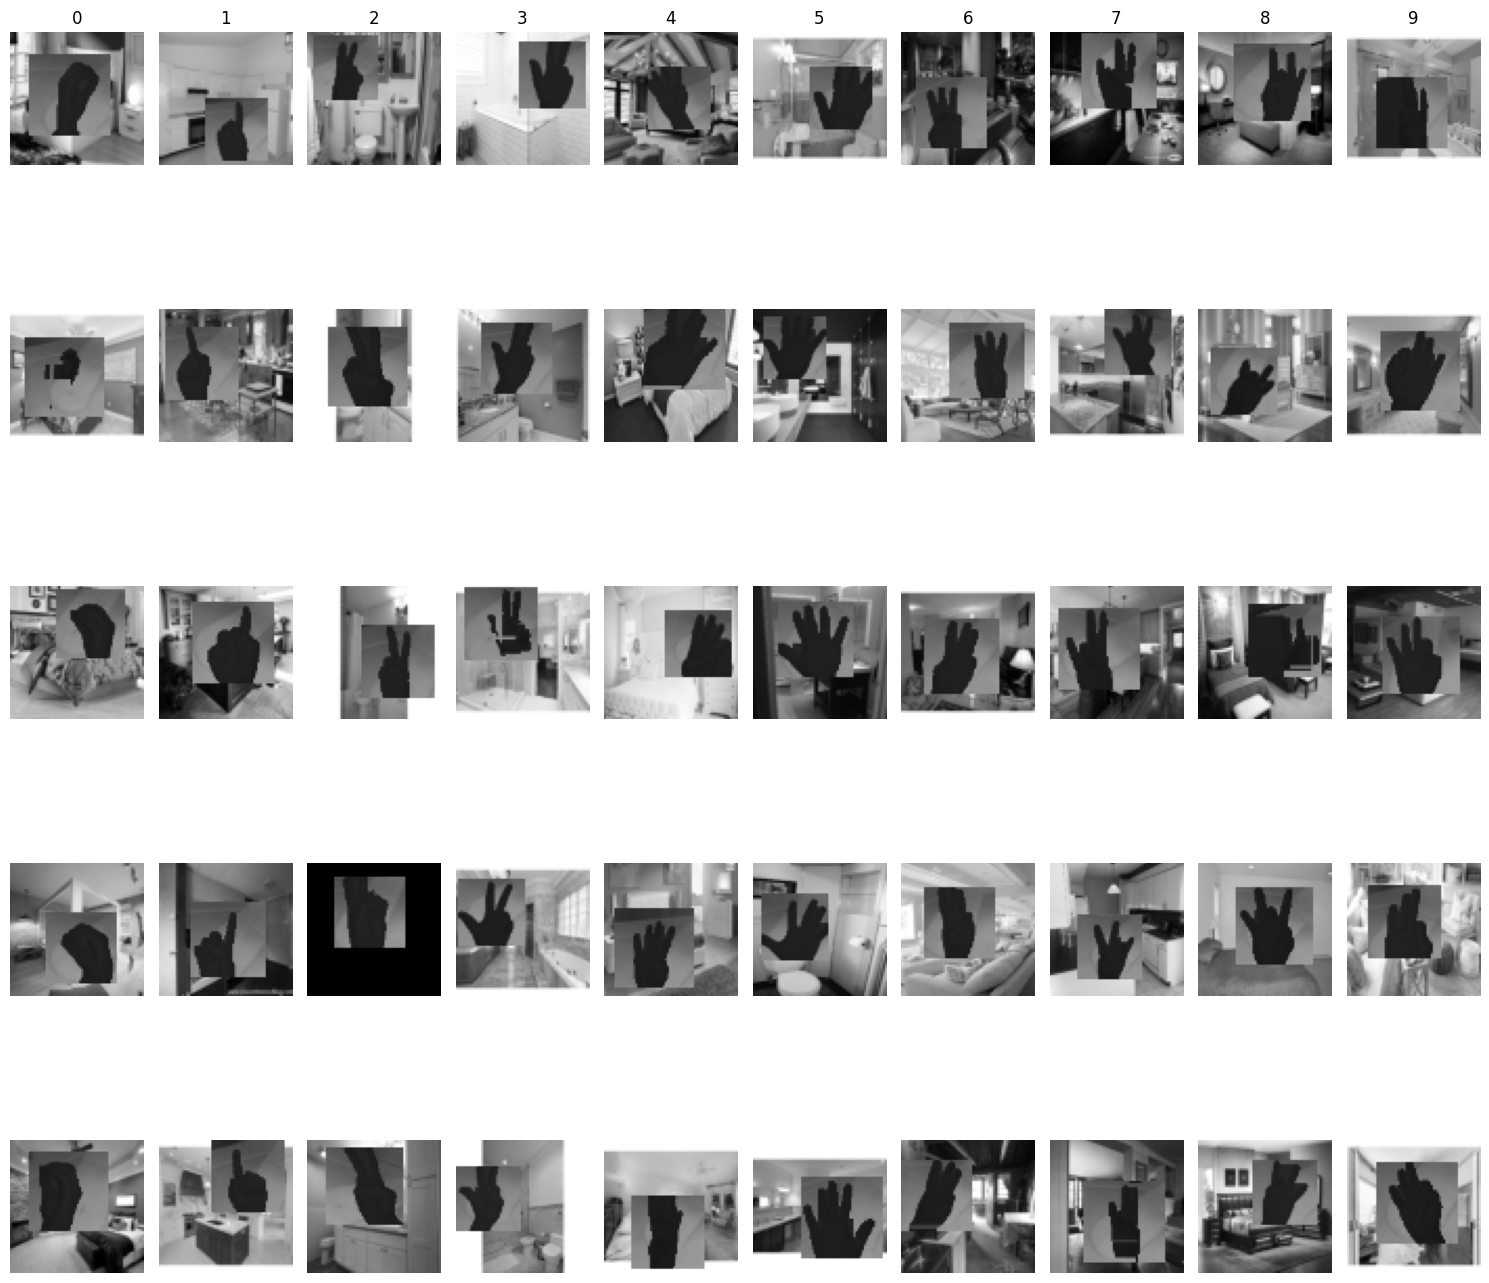

In [13]:
f,ax=plt.subplots(5,10,figsize=(15,15))
for i in range(10):
  ax[0][i].set_title(str(i))
  low=np.random.randint(0,2062*k)
  while low>len(Y_all)-2062:
    low=np.random.randint(0,2062*k)
  while list(Y_all[low]).index(1.0)!=i:
    low+=1
  high=low
  while list(Y_all[high]).index(1.0)==i:
    high+=1
    if high==2062*k-1:
      high=2062*k
      break
  high-=1
  for a in range(5):
    r=np.random.randint(low,high)
    ax[a][i].imshow(X_new[r],cmap='gray',vmin=0,vmax=1)
    ax[a][i].set_axis_off()
f.tight_layout()

In [ ]:
X_new=np.zeros((13506,64,64))
X_new[:2062*k]=X_all_bin.copy()
X_new[2062*k:2062*k+3800]=bg.copy()
X_new[2062*k+3800:]=tbg.copy()
Y_new=np.zeros((13506,11))
Y_new[:2062*k,1:]=Y_all.copy()
Y_new[2062*k:,0]=1

In [ ]:
X_new=X_new[:len(X_all)-2062]
Y_all=Y_all[:len(X_new)]

In [15]:
#X_new=np.expand_dims(X_new,axis=-1)
X_new=X_new[:2062*k-2062]
Y_all=Y_all[:len(X_new)]
x_train, x_test, y_train, y_test=train_test_split(X_new,Y_all,test_size=0.3,random_state=42)
x_train = x_train.astype('float32')*255
x_test  = x_test.astype('float32')*255

Epoch 1/30
722/722 [==============================] - 7s 8ms/step - loss: 2.7862 - accuracy: 0.1002 - val_loss: 2.3024 - val_accuracy: 0.1027
Epoch 2/30
722/722 [==============================] - 5s 8ms/step - loss: 2.2791 - accuracy: 0.1401 - val_loss: 2.2570 - val_accuracy: 0.1561
Epoch 3/30
722/722 [==============================] - 5s 7ms/step - loss: 2.1902 - accuracy: 0.1961 - val_loss: 2.1495 - val_accuracy: 0.2106
Epoch 4/30
722/722 [==============================] - 4s 6ms/step - loss: 2.0049 - accuracy: 0.2796 - val_loss: 1.9128 - val_accuracy: 0.3195
Epoch 5/30
722/722 [==============================] - 5s 8ms/step - loss: 1.7708 - accuracy: 0.3715 - val_loss: 1.7467 - val_accuracy: 0.3814
Epoch 6/30
722/722 [==============================] - 5s 6ms/step - loss: 1.5425 - accuracy: 0.4572 - val_loss: 1.5714 - val_accuracy: 0.4492
Epoch 7/30
722/722 [==============================] - 5s 6ms/step - loss: 1.3608 - accuracy: 0.5213 - val_loss: 1.5180 - val_accuracy: 0.4763
Epoch 

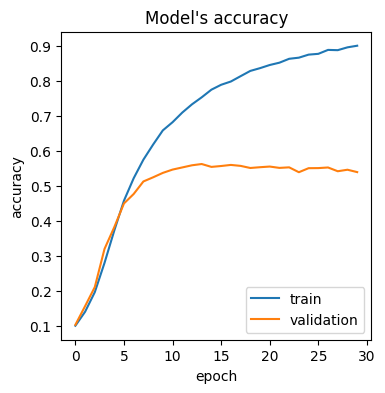

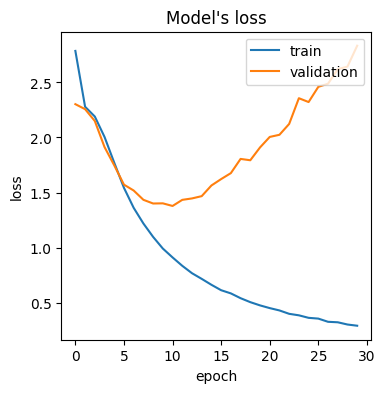

In [17]:
model=create_network()
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
history=model.fit(x_train,y_train,
                  validation_data=(x_test,y_test),
                  callbacks=None,
                  epochs=30,
                  batch_size=50)
scores=model.evaluate(x_test,y_test)
print('Train accuracy: %.2f%%' % (history.history['accuracy'][-1]*100))
print('Validation accuracy: %.2f%%' % (scores[1]*100))
print('Accuracy and loss plot:')
plot_acc(history)

Epoch 1/10
722/722 [==============================] - 5s 7ms/step - loss: 0.2886 - accuracy: 0.8996 - val_loss: 2.8715 - val_accuracy: 0.5450
Epoch 2/10
722/722 [==============================] - 5s 6ms/step - loss: 0.2653 - accuracy: 0.9081 - val_loss: 2.8924 - val_accuracy: 0.5478
Epoch 3/10
722/722 [==============================] - 5s 7ms/step - loss: 0.2540 - accuracy: 0.9108 - val_loss: 3.1530 - val_accuracy: 0.5393
Epoch 4/10
722/722 [==============================] - 5s 7ms/step - loss: 0.2474 - accuracy: 0.9142 - val_loss: 3.1375 - val_accuracy: 0.5414
Epoch 5/10
722/722 [==============================] - 4s 6ms/step - loss: 0.2304 - accuracy: 0.9208 - val_loss: 3.2480 - val_accuracy: 0.5405
Epoch 6/10
722/722 [==============================] - 5s 7ms/step - loss: 0.2444 - accuracy: 0.9139 - val_loss: 3.3135 - val_accuracy: 0.5410
Epoch 7/10
722/722 [==============================] - 5s 7ms/step - loss: 0.2269 - accuracy: 0.9214 - val_loss: 3.3847 - val_accuracy: 0.5336
Epoch 

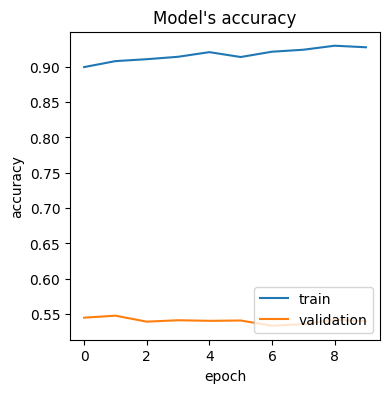

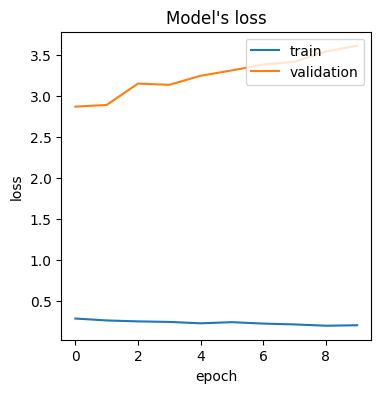

In [18]:
history=model.fit(x_train,y_train,
                  validation_data=(x_test,y_test),
                  callbacks=None,
                  epochs=10,
                  batch_size=50)
scores=model.evaluate(x_test,y_test)
print('Train accuracy: %.2f%%' % (history.history['accuracy'][-1]*100))
print('Validation accuracy: %.2f%%' % (scores[1]*100))
print('Accuracy and loss plot:')
plot_acc(history)

In [26]:
def representative_dataset():
  for data in tf.data.Dataset.from_tensor_slices((x_train)).batch(1):
    yield [tf.dtypes.cast(data, tf.float32)]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset

converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

tflite_quant_model = converter.convert()

/usr/local/lib/python3.9/dist-packages/tensorflow/lite/python/convert.py:789: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


In [27]:
with open('./drive/MyDrive/rmodel.tflite', 'wb') as output:
    print(len(tflite_quant_model))
    output.write(tflite_quant_model)

64616
